# 생활폐기물 예측 모델 

생활 폐기물 종류 중 재활용 을 제외한 매립과 소각 관련 생활 폐기물 발생량에 대한 예측을 목적으로 함. 

수집한 전체 데이터에 대한 기본적인 탐색 분석을 진행하고 주요한 변수를 선택하여 모델링에 사용.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 한글 깨짐 해결 
from matplotlib import rc
rc('font', family='NanumMyeongjo')
plt.rcParams['axes.unicode_minus'] = False

# 숫자 format 옵션 
pd.set_option('display.float_format', lambda x : '%.3f' %x)


# output Columns options
pd.set_option('max_columns', 500)

# RdGy 지정
sns.set_palette("RdGy")

In [3]:
data = pd.read_csv('./data/최종데이터셋ver2.csv')
#data.info()

In [4]:
# object 형태로 저장된 가구 관련 변수를 숫자형으로 변환 

data['총가구수'] = data['총가구수'].str.replace(",","").astype(int)
data['1인가구수'] = data['1인가구수'].str.replace(",","").astype(int)
data['2인가구수'] = data['2인가구수'].str.replace(",","").astype(int)
data['다가구.수'] = data['다가구.수'].str.replace(",","").astype(int)
#data.info()

## EDA : 기술통계 + 그래프 

In [5]:
# 탐색적 분석 검정에 사용하는 모듈
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats

### 생활폐기물 발생량 추이 

In [6]:
mean = data['생활폐기물발생량'].mean()
median = data['생활폐기물발생량'].median()
print(mean, median)

140922.95245515337 138510.0


#### 생활 폐기물 일일 발생량 평균 : 약 140 톤 , 중간값 : 약 138 톤

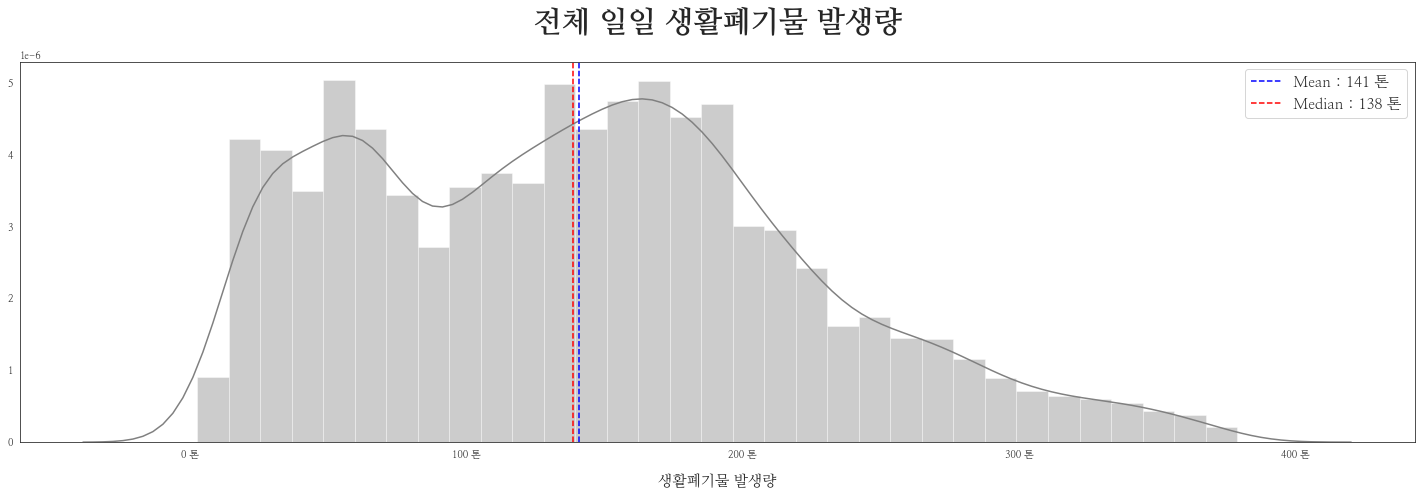

In [7]:
plt.figure(figsize = (25,7))
sns.distplot(data['생활폐기물발생량'], color = 'grey')
plt.axvline(mean, color='b', linestyle='--')
plt.axvline(median, color='r', linestyle='--')
plt.title('전체 일일 생활폐기물 발생량', size = 30, fontweight = 'bold', pad = 30)
plt.legend({'Mean : 141 톤' :mean,'Median : 138 톤':median}, prop ={'size' : 15})


xlabel  = ['0 톤','100 톤','200 톤','300 톤','400 톤']
nthreads = [0,100000,200000,300000,400000]
plt.xticks(nthreads, xlabel)
plt.xlabel('생활폐기물 발생량', fontsize = 15, labelpad =15)

plt.savefig('./image/전체 일일 생활폐기물 발생량.png',bbox_inches='tight')

### 연도별 생활폐기물 발생량 변화 

In [8]:
temp = data[['날짜','구별','생활폐기물발생량']]
temp.head(3)

,날짜,구별,생활폐기물발생량
0,2015-01-02,계양구,115160.952
1,2015-01-05,계양구,126700.952
2,2015-01-06,계양구,117700.952


In [9]:
temp['날짜'] = pd.to_datetime(temp['날짜'])
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   날짜        9427 non-null   datetime64[ns]
 1   구별        9427 non-null   object        
 2   생활폐기물발생량  9427 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 221.1+ KB


In [10]:
temp['연도'] = temp['날짜'].dt.year
temp['연도'] = temp['연도'].astype(str)
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   날짜        9427 non-null   datetime64[ns]
 1   구별        9427 non-null   object        
 2   생활폐기물발생량  9427 non-null   float64       
 3   연도        9427 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 294.7+ KB


In [11]:
group = temp.groupby(['구별','연도'])

In [12]:
df = group.sum()

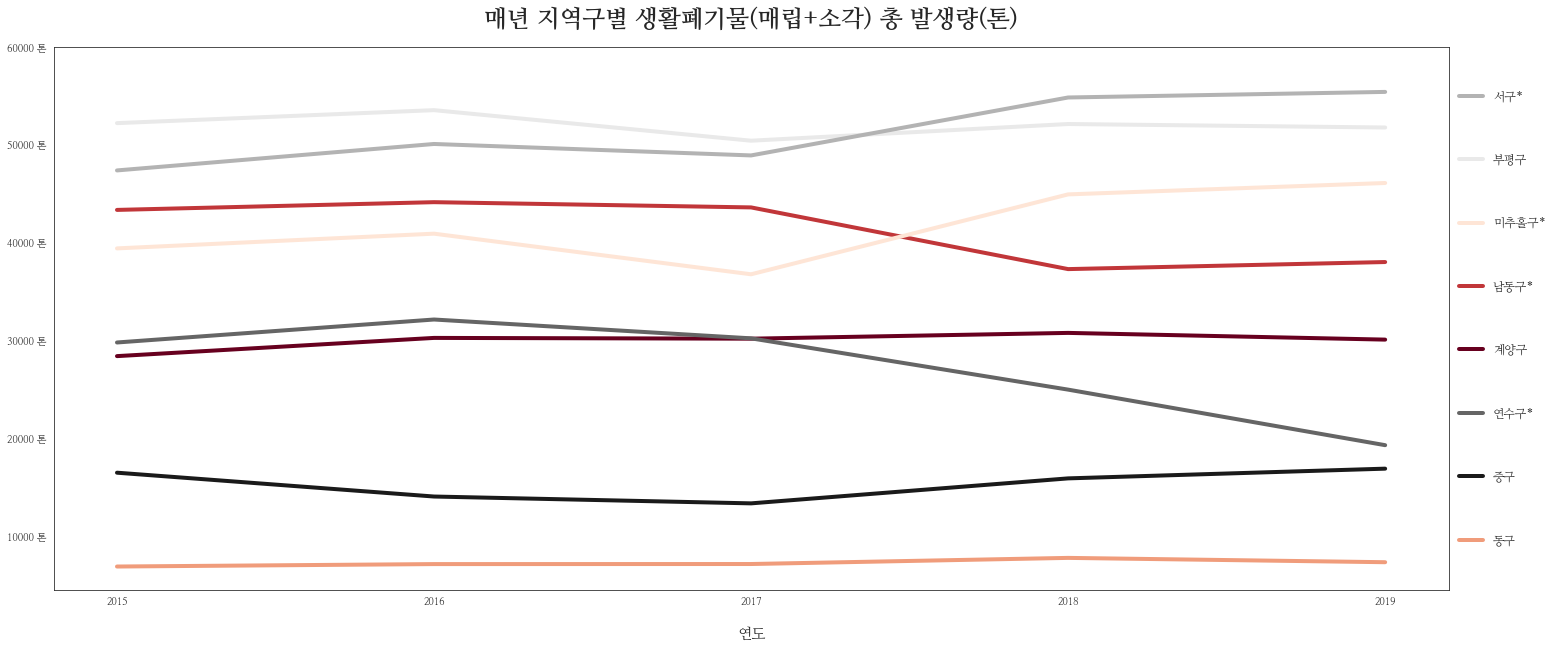

In [13]:
ax = df.reset_index().pivot('연도', '구별','생활폐기물발생량').plot(figsize = (25,10), colormap ='RdGy', linewidth = 4)

handles, labels = ax.get_legend_handles_labels()
# print(handles, labels)
handles = [handles[5], handles[4], handles[3],handles[1], handles[0], handles[6],handles[7], handles[2]]
labels = [labels[5]+"*", labels[4], labels[3]+"*", labels[1]+"*",labels[0], labels[6]+"*", labels[7], labels[2]]

plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), 
                labelspacing=4.2, frameon=False, prop={'size':12})


ax.set_title('매년 지역구별 생활폐기물(매립+소각) 총 발생량(톤)', pad=20, fontdict={'fontsize':24,
                                                    'fontweight':'bold'})

plt.xlabel('연도', fontsize=15, labelpad=20)

ylabel  = ['10000 톤','20000 톤','30000 톤','40000 톤','50000 톤','60000 톤']
nthreads = [10000000,20000000,30000000,40000000,50000000,60000000]

plt.yticks(nthreads, ylabel)

plt.savefig('./image/연도별 지역구 생활폐기물 총 발생량.png',bbox_inches='tight')

In [14]:
df2 = df.reset_index().pivot('연도', '구별','생활폐기물발생량')
#df2.to_excel('매해구별 총 생활폐기물발생량.xlsx')

### 구별 생활폐기물 발생량

<Figure size 432x288 with 0 Axes>

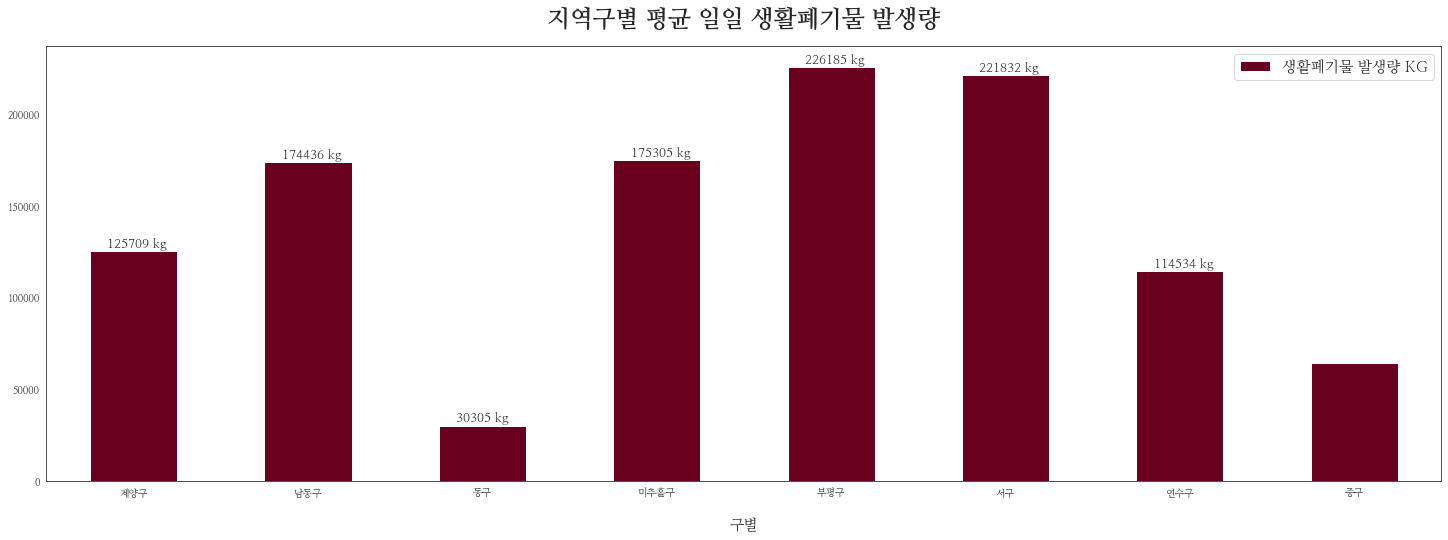

In [15]:
# 구별 평균 생활쓰레기 발생량 
plt.figure()
trasha = data.groupby(['구별'], as_index=False).mean()[['구별','생활폐기물발생량']]
ax = trasha.plot(x='구별', y='생활폐기물발생량', kind ='bar', rot=0, colormap ='RdGy',
           figsize = (25,8))

labels = trasha['생활폐기물발생량'].tolist()
j = 2000

for i in range(7):
    plt.annotate(r'{:.0f} kg'.format(labels[i]), ( -0.15 + i, labels[i]+j), fontsize = 13)

plt.legend(labels = ['생활폐기물 발생량 KG'],prop ={'size' : 15})
ax.set_title('지역구별 평균 일일 생활폐기물 발생량', pad=20, fontdict={'fontsize':24,
                                                    'fontweight':'bold'})
plt.xlabel('구별', fontsize=15, labelpad=20)

plt.savefig('./image/구별 평균 일일 생활폐기물 발생량.png', bbox_inches='tight')

In [16]:
trasha.transpose().to_excel('구별폐기물량.xlsx')

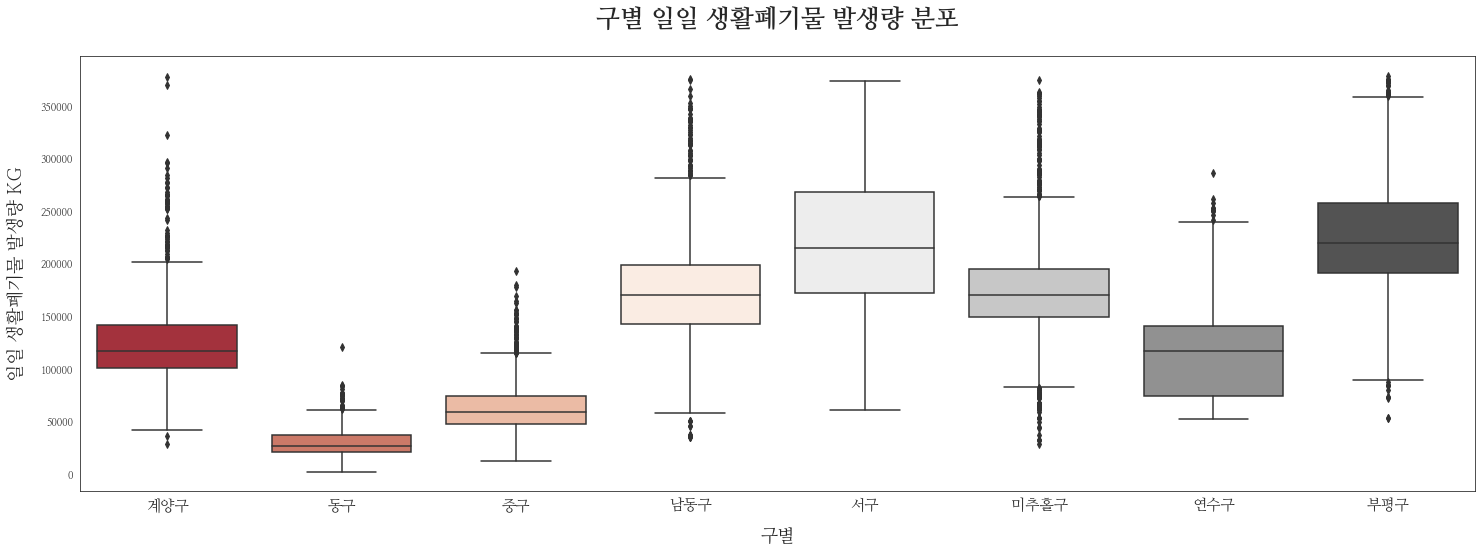

In [17]:
# 구별 생활쓰레기 발생량 분포 
plt.figure(figsize = (25,8))
sns.boxplot(x="구별", y="생활폐기물발생량",data=data, palette = 'RdGy')
plt.title('구별 일일 생활폐기물 발생량 분포', size = 25, fontweight = 'bold', pad = 30)
plt.xticks(fontsize =15)
plt.xlabel('구별', size = 18, labelpad= 15)
plt.ylabel('일일 생활폐기물 발생량 KG', size = 18, labelpad = 15)
plt.savefig('./image/구별 생활폐기물 발생량 분포.png', bbox_inches='tight')

In [18]:
model = ols('생활폐기물발생량 ~ C(구별)', data).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(구별),7.000,41261468241559.789,5894495463079.970,2701.073,0.000
Residual,9419.000,20554884200044.242,2182278819.412,nan,nan


In [19]:
comp = MultiComparison(data.생활폐기물발생량, data.구별 )
tukeyhsd = comp.tukeyhsd(alpha = 0.05)
tukeyhsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
계양구,남동구,48727.2794,0.001,42910.4649,54544.094,True
계양구,동구,-95403.6621,0.001,-101213.1058,-89594.2183,True
계양구,미추홀구,49596.1103,0.001,43784.2169,55408.0037,True
계양구,부평구,100475.9755,0.001,94617.4218,106334.5292,True
계양구,서구,96123.5116,0.001,90273.9854,101973.0377,True
계양구,연수구,-11174.5421,0.001,-16982.7637,-5366.3205,True
계양구,중구,-61391.6617,0.001,-67201.1054,-55582.2179,True
남동구,동구,-144130.9415,0.001,-149948.9763,-138312.9066,True
남동구,미추홀구,868.8309,0.9,-4951.6501,6689.3118,False
남동구,부평구,51748.6961,0.001,45881.6231,57615.769,True


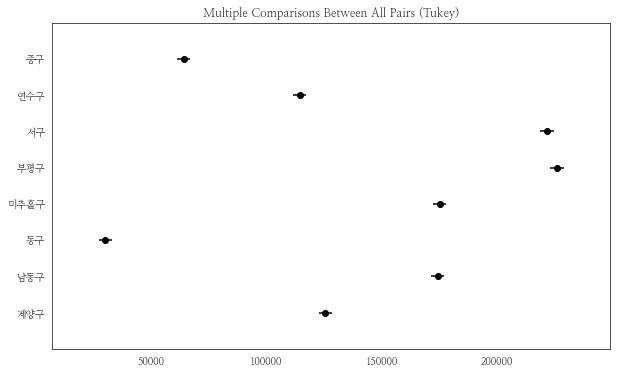

In [20]:
fig = tukeyhsd.plot_simultaneous()
#plt.savefig('./image/사후분석결과.png', bbox_inches ='tight')

### 요일에 따른 생활쓰레기 발생량

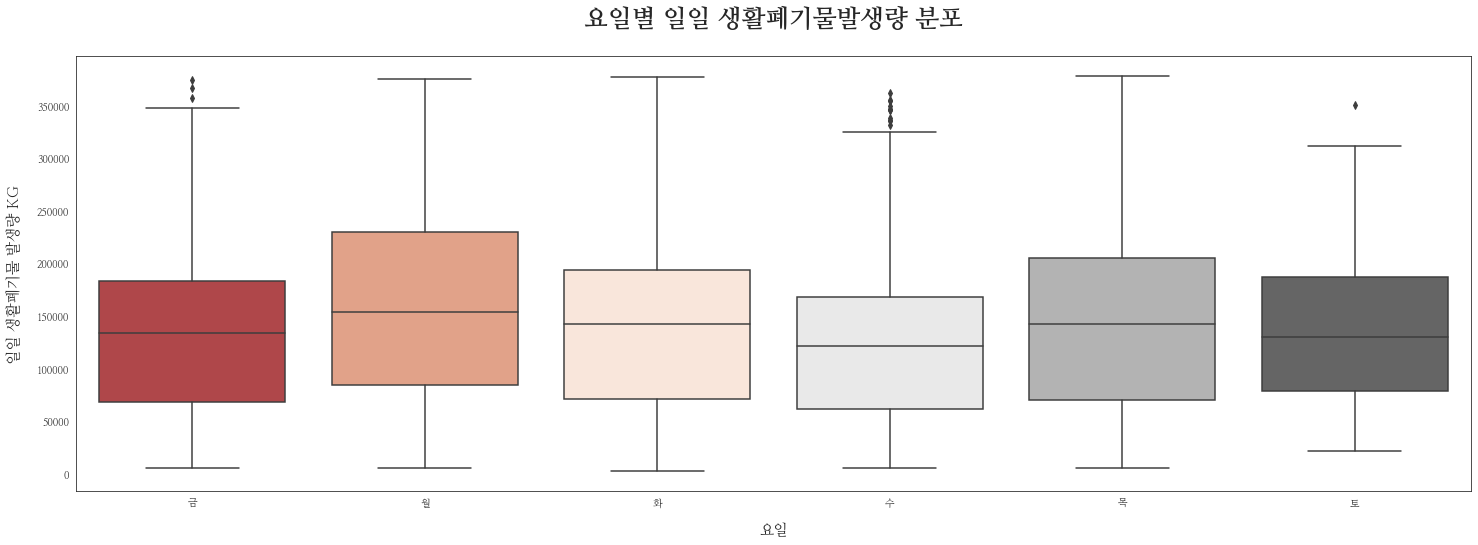

In [21]:
# 요일별 생활쓰레기 발생량 분포 
plt.figure(figsize = (25,8))
sns.boxplot(x="요일",y="생활폐기물발생량",data=data, palette = 'RdGy')
plt.title('요일별 일일 생활폐기물발생량 분포', size = 25, fontweight = 'bold', pad = 30)
plt.xlabel('요일', fontsize = 15, labelpad = 15)
plt.ylabel('일일 생활폐기물 발생량 KG', size = 15, labelpad = 15)
plt.savefig('./image/요일별 생활폐기물발생량 분포.png',bbox_inches='tight')

In [22]:
model = ols('생활폐기물발생량 ~ C(요일)', data).fit()

anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(요일),5.000,1774921312599.193,354984262519.839,55.700,0.000
Residual,9421.000,60041431129005.328,6373148405.584,nan,nan


In [23]:
comp = MultiComparison(data.생활폐기물발생량, data.요일)

In [24]:
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
금,목,-4.4908,0.0,0.0001,True
금,수,6.0404,0.0,0.0,True
금,월,-10.5825,0.0,0.0,True
금,토,-0.4405,0.6596,1.0,False
금,화,-2.5256,0.0116,0.1739,False
목,수,10.0423,0.0,0.0,True
목,월,-5.7901,0.0,0.0,True
목,토,0.4706,0.638,1.0,False
목,화,1.9652,0.0495,0.7419,False
수,월,-16.0706,0.0,0.0,True


요일에 따라 생활폐기물 발생량에 차이가 있는 것으로 보임.  
하지만 가설로 새울 수 있는 월요일과 토요일이 차이 등 모든 그룹들간의 차이가 나지 않고  
폐기물 발생량 데이터를 소각소와 매립지에서 들어오는 반입량으로 설정했기 때문에 오류가 발생할 가능성이 있음.    
자원순환과 문의 결과 소각처리시설의 경우 처리 용량이 한정적이고 이를 초과할 경우 반입이 불가능하여 해당 일자의 발생량이 이월될 가능성이 존재함. 

### 주택 유형과 생활폐기물 발생량 

각 데이터는 호수를 의미하며 예를 들어 아파트의 경우 101동에 100개의 호가 있으면 값에 100을 측정.  
지역구별 단독주택, 아파트, 연립주택, 다세대주택에 대한 수가 다름.   
그 유형별 양에 따라 생활폐기물 발생량에 대한 영향도를 파악하고 싶음.  


In [25]:
trashc = data.groupby(['주택계'], as_index=False).mean()
trashc = trashc[['주택계','생활폐기물발생량']]

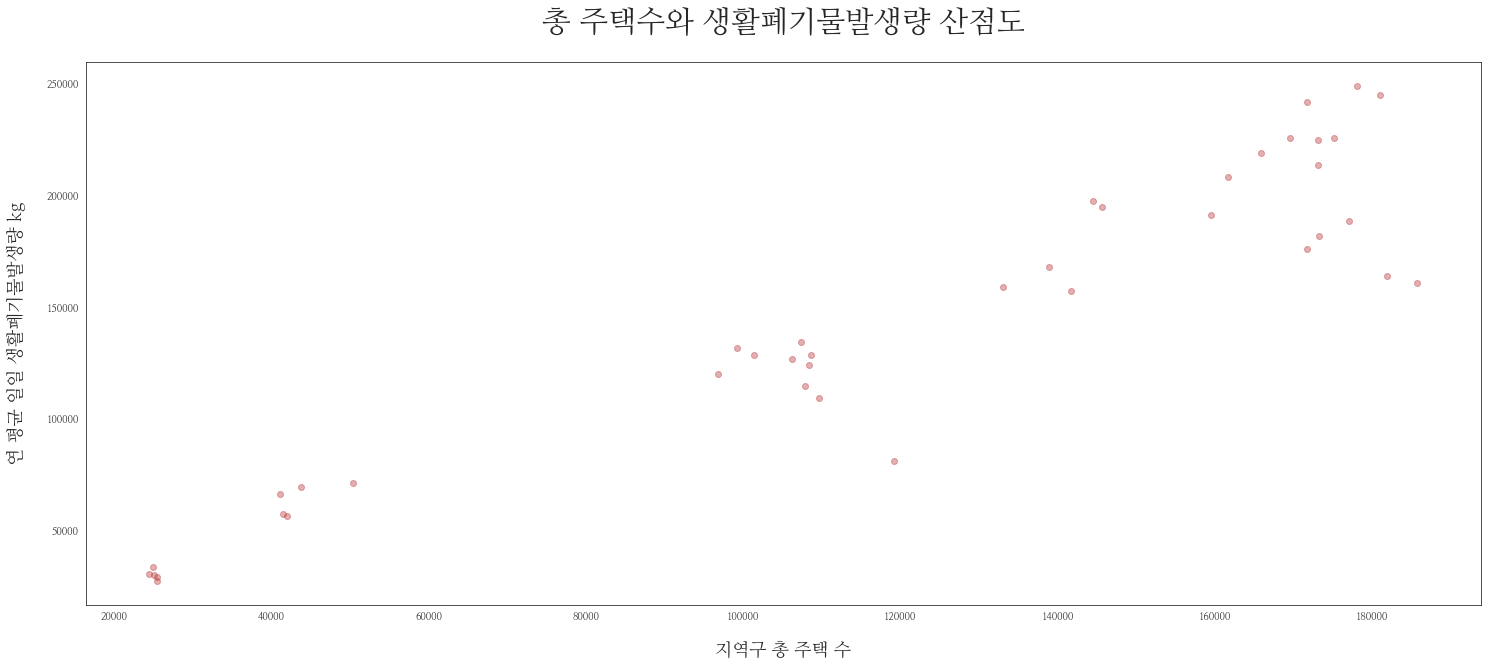

In [26]:
plt.figure(figsize = ( 25, 10))
plt.scatter(trashc['주택계'], trashc['생활폐기물발생량'], alpha = 0.4, color = '#B9383A')
plt.title('총 주택수와 생활폐기물발생량 산점도', fontsize = 30, pad = 30)
plt.xlabel('지역구 총 주택 수', labelpad = 20, size = 18)
plt.ylabel('연 평균 일일 생활폐기물발생량 kg', labelpad = 20, size = 18)
plt.savefig('./image/총주택수와 생활폐기물 발생량 산점도.png', bbox_inches = 'tight')

In [27]:
house = data[['날짜','구별','단독주택','아파트','연립주택','다세대주택']]
house.head(3)

,날짜,구별,단독주택,아파트,연립주택,다세대주택
0,2015-01-02,계양구,4079,68277,2108,32740
1,2015-01-05,계양구,4079,68277,2108,32740
2,2015-01-06,계양구,4079,68277,2108,32740


In [28]:
house['날짜'] = pd.to_datetime(house['날짜'])
house['연도'] = house['날짜'].dt.year
house['연도'] = house['연도'].astype(str)
house.head(3)

,날짜,구별,단독주택,아파트,연립주택,다세대주택,연도
0,2015-01-02,계양구,4079,68277,2108,32740,2015
1,2015-01-05,계양구,4079,68277,2108,32740,2015
2,2015-01-06,계양구,4079,68277,2108,32740,2015


In [29]:
df = house.drop_duplicates(subset=["구별","단독주택","아파트","연립주택","다세대주택"])
df.drop(["날짜"],axis =1, inplace =True)
df.head(10)

,구별,단독주택,아파트,연립주택,다세대주택,연도
0,계양구,4079,68277,2108,32740,2015
247,계양구,4109,68528,2108,33013,2016
490,계양구,4094,68650,2149,33090,2017
724,계양구,3940,67942,1828,33060,2018
952,계양구,3770,67831,1730,32293,2019
1189,동구,7682,14393,188,2916,2015
1436,동구,7653,14393,188,2980,2016
1679,동구,7138,14393,258,2987,2017
1913,동구,7065,14393,258,3012,2018
2141,동구,6442,14429,320,3031,2019


In [30]:
서구 = df[df.구별 =="서구"].set_index('연도')
미추홀구 = df[df.구별 =="미추홀구"].set_index('연도')
남동구 = df[df.구별 =="남동구"].set_index('연도')
연수구 = df[df.구별 =="연수구"].set_index('연도')

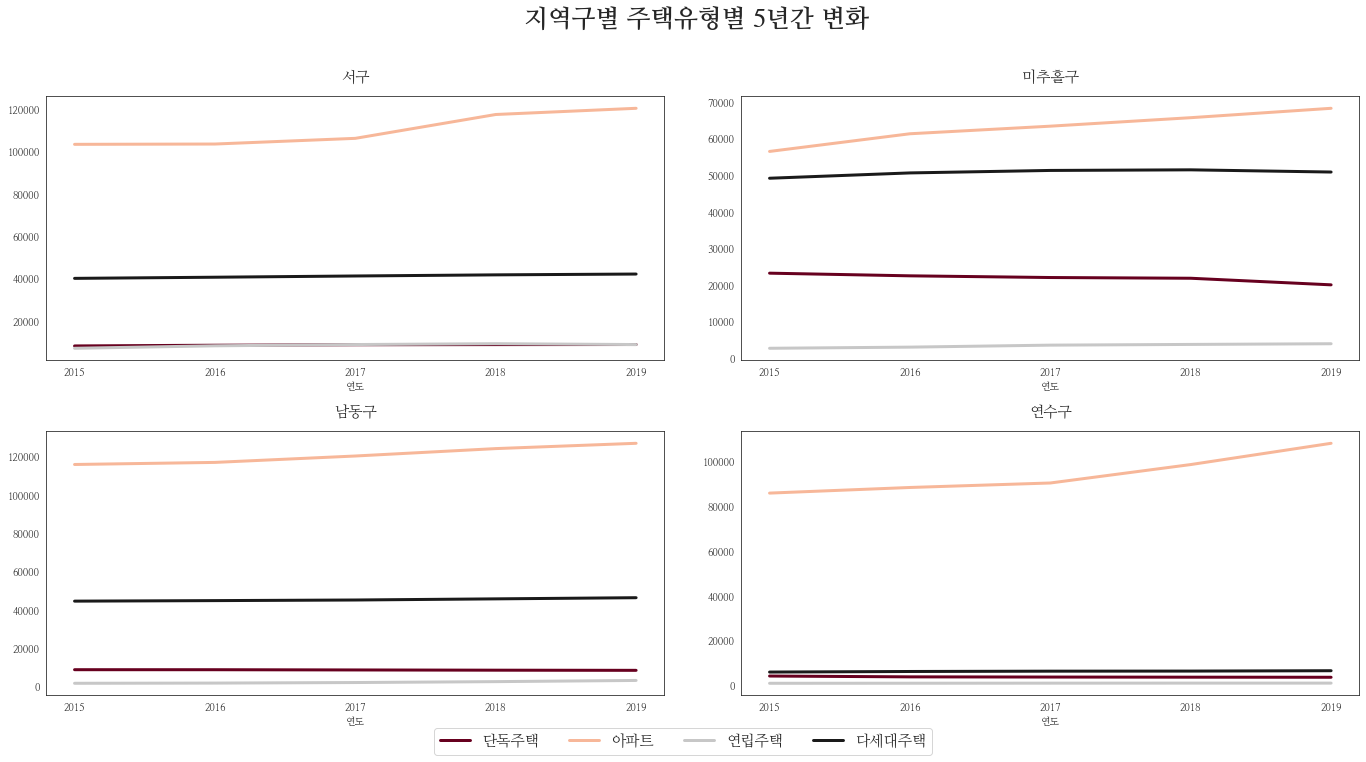

In [31]:
fig, axes = plt.subplots(2,2, figsize = (20,10))
fig.tight_layout(pad=5.0)


li = [서구,미추홀구, 남동구, 연수구]
lis = ['서구','미추홀구', '남동구','연수구']

for i, ax in enumerate(axes.flat):
    li[i].plot(ax = ax ,cmap = 'RdGy',legend = False, linewidth = 3)
    ax.set_title(lis[i], pad = 15, fontsize = 15 )
    handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc="lower center", ncol = len(ax.lines),
          fontsize = 15)

fig.suptitle('지역구별 주택유형별 5년간 변화', size = 25, fontweight = 'bold',  y = 1.05)
plt.savefig('./image/지역구별 주택유형별 현황.png', bbox_inches ='tight')

In [32]:
서구

,구별,단독주택,아파트,연립주택,다세대주택
연도,,,,,
2015,서구,8080,103434,6973,40043
2016,서구,8416,103579,8144,40586
2017,서구,8645,106269,8743,41172
2018,서구,8715,117547,9147,41703
2019,서구,8754,120480,8738,42088


In [33]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

In [34]:
x = data[['단독주택', '아파트','연립주택','다세대주택']]
y = data[['생활폐기물발생량']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

model = LinearRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print(model.coef_)

[[1.9052133  0.91161008 8.56930009 0.91120375]]


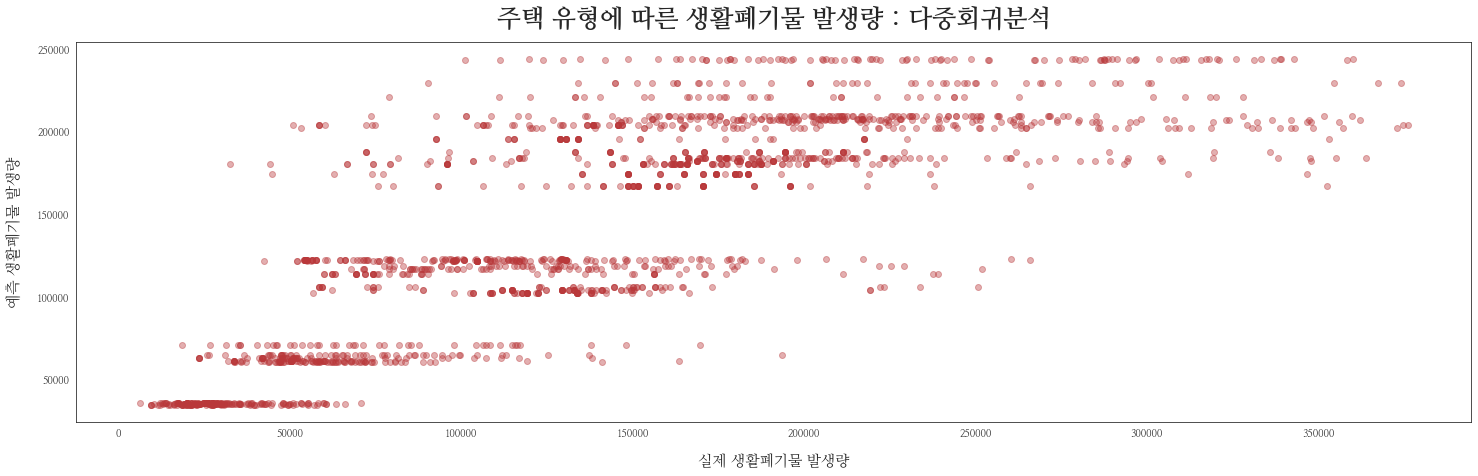

In [35]:
plt.figure(figsize = (25,7))
plt.scatter(y_test, pred, alpha = 0.4, color = '#B9383A')
plt.xlabel('실제 생활폐기물 발생량', labelpad = 15, size = 15)
plt.ylabel('예측 생활폐기물 발생량', labelpad = 15, size = 15)
plt.title('주택 유형에 따른 생활폐기물 발생량 : 다중회귀분석', size = 25, weight = 'bold', pad =15)
plt.savefig('./image/주택유형에 따른 다중회귀분석.png', bbox_inches = 'tight')

In [36]:
mod = ols(formula = '생활폐기물발생량 ~ 단독주택 + 아파트 + 연립주택 + 다세대주택', data = data)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               생활폐기물발생량   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     4423.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:16:23   Log-Likelihood:            -1.1494e+05
No. Observations:                9427   AIC:                         2.299e+05
Df Residuals:                    9422   BIC:                         2.299e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3819.4424   1569.004      2.434      0.015     743.856    6895.029
단독주택           1.9828      0.142     13.964      0.000       1.704       2.261
아파트            0.9102      0.022     41.068      0.000       0.867       0.954
연립주택           8.6254      0.269     32.055      0.000       8.098       9.153
다세대주택          0.8794      0.057     15.419      0.000       0.768       0.991
==============================================================================
Omnibus:                      743.200   Durbin-Watson:                   1.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1598.941
Skew:                           0.514   Prob(JB):                         0.00
Kurtosis:                       4.736   Cond. No.                     2.88e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
house = data[['총인구','아파트','단독주택','연립주택','다세대주택']]

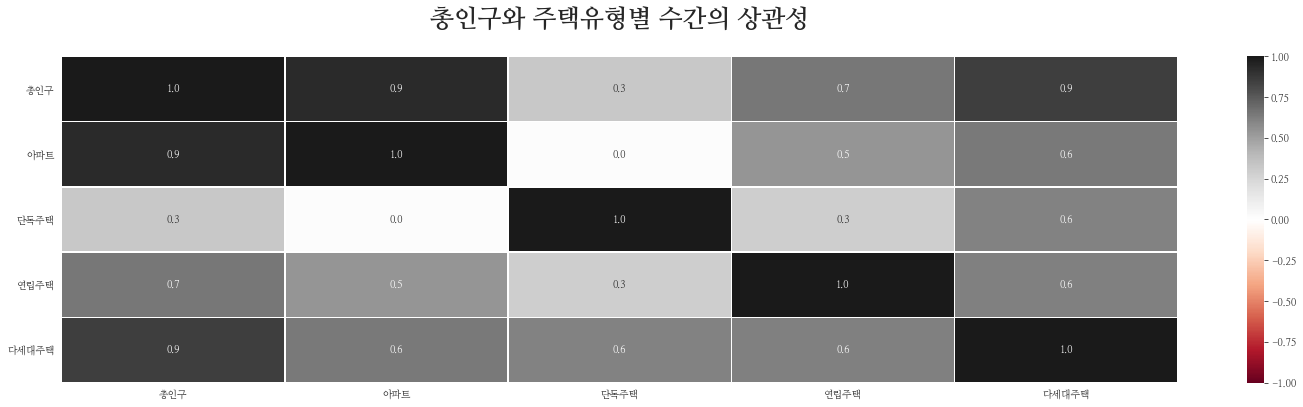

In [38]:
plt.figure(figsize = (25,6))
sns.heatmap(house.corr(), cmap='RdGy', linewidth = 0.3, annot= True, fmt = '.1f', annot_kws={'size':10},
           vmin = -1, vmax =1)
plt.title('총인구와 주택유형별 수간의 상관성', size = 25, fontweight = 'bold', pad = 30)
plt.yticks(rotation ='horizontal')
plt.savefig('./image/총인구와주택유형간의상관분석.png',bbox_inches='tight')

주택 유형 관련 변수 중 단독주택을 제외하고 모두 총인구와 상관성이 높은 변수들.   
특히 아파트 변수의 경우 0.9로 매우 높은 상관성을 보이고 있으며   
아파트는 인천광역시의 주거 환경 중 80% 이상을 차지하고 있기 때문에 아파트 변수를 통해 총 인구에 대한 설명력을 대신할 것으로 판단됨. 

### 날씨에 따른 생활폐기물 발생량 

In [39]:
wea = data[['날짜','생활폐기물발생량','강수량','평균기온']]
wea.head(3)

,날짜,생활폐기물발생량,강수량,평균기온
0,2015-01-02,115160.952,0.000,-5.300
1,2015-01-05,126700.952,0.500,4.200
2,2015-01-06,117700.952,0.900,-3.200


In [40]:
wea.loc[wea['평균기온'] <= -10, '기온그룹'] = 1
wea.loc[(wea['평균기온'] > -10) & (wea['평균기온'] <= 0) , '기온그룹'] = 2
wea.loc[(wea['평균기온'] > 0) & (wea['평균기온'] <=10) , '기온그룹'] =3
wea.loc[(wea['평균기온'] > 10) & (wea['평균기온'] <=30), '기온그룹']=4
wea.loc[wea['평균기온'] > 30 , '기온그룹'] = 5 
wea.head(3)

,날짜,생활폐기물발생량,강수량,평균기온,기온그룹
0,2015-01-02,115160.952,0.000,-5.300,2.000
1,2015-01-05,126700.952,0.500,4.200,3.000
2,2015-01-06,117700.952,0.900,-3.200,2.000


In [41]:
wea['기온그룹'] = wea['기온그룹'].astype(int).astype(str)
wea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   날짜        9427 non-null   object 
 1   생활폐기물발생량  9427 non-null   float64
 2   강수량       9427 non-null   float64
 3   평균기온      9427 non-null   float64
 4   기온그룹      9427 non-null   object 
dtypes: float64(3), object(2)
memory usage: 368.4+ KB


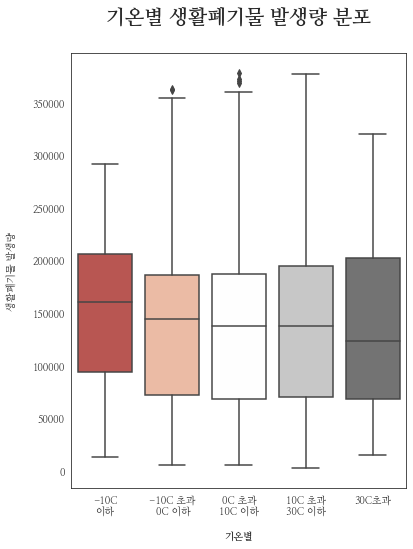

In [42]:
# 기온 그룹별  생활쓰레기 발생량 분포 
plt.figure(figsize = (6,8))
sns.boxplot(x="기온그룹",y="생활폐기물발생량",data=wea, palette = 'RdGy')
plt.title('기온별 생활폐기물 발생량 분포', size = 20, fontweight = 'bold', pad = 30)
plt.xticks([0,1,2,3,4], ['-10C\n이하', '-10C 초과\n 0C 이하', '0C 초과\n10C 이하','10C 초과\n30C 이하','30C초과'] )
plt.xlabel('기온별', labelpad = 15, fontweight = 'bold')
plt.ylabel('생활폐기물 발생량', labelpad = 15)

plt.savefig('./image/기온별 생활폐기물 발생량 분포.png',bbox_inches='tight')

In [43]:
wea.loc[wea['강수량'] <= 0, '강수그룹'] = "강수량 = 0"
wea.loc[(wea['강수량'] > 0) & (wea['강수량'] <= 30) , '강수그룹'] = "0 < 강수량 <= 30 "
wea.loc[(wea['강수량'] > 0) & (wea['강수량'] <=10) , '강수그룹'] = "30 < 강수량"

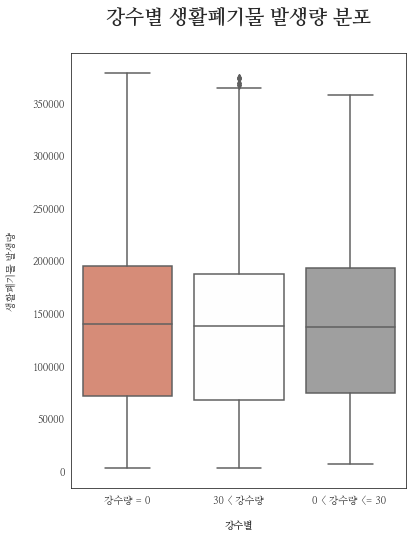

In [44]:
# 강수 그룹별  생활쓰레기 발생량 분포 
plt.figure(figsize = (6,8))
sns.boxplot(x="강수그룹",y="생활폐기물발생량",data=wea, palette = 'RdGy')
plt.title('강수별 생활폐기물 발생량 분포', size = 20, fontweight = 'bold', pad = 30)
plt.xlabel('강수별', labelpad = 15, fontweight = 'bold')
plt.ylabel('생활폐기물 발생량', labelpad =15)
plt.savefig('./image/강수별 생활폐기물 발생량.png', bbox_inches ='tight')

### 용도지역의 영향 
용도지역은 법률에 따라 주거지역, 상업지역, 공업지역, 녹지지역으로 구분한다.  
이 중 생활폐기물 발생의 거점이 될 것으로 파악되는 주거, 상업, 공업에 대한 데이터를 사용한다. 

    * 주거지역
    * 상업지역 
    * 공업지역

In [45]:
spot = data[['구별','주거지역소계','주거지역비율','상업지역소계','상업지역비율','공업지역소계','공업지역비율']]
spot.drop_duplicates().to_excel('용도지역.xlsx')

용도지역 데이터는 매년 크게 변화하는 값이 아니고, 데이터의 수집 및 변경 주기가 일정하지 않지 않다.   
또한 미묘한 변화가 발생하더라도 테이블 형태로 수정되거나 기록되는 것이 아닌 변경에 대한 이력만 저장하고 있는 현황. 

#### 용도지역에 따른 생활폐기물 발생량 영향

In [46]:
spot = data[['구별','주거지역소계','주거지역비율','상업지역소계','상업지역비율','공업지역소계','공업지역비율','생활폐기물발생량']]

In [47]:
mod = ols(formula = '생활폐기물발생량 ~ 주거지역소계+주거지역비율+상업지역소계+상업지역비율+공업지역소계+공업지역비율', data = data)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               생활폐기물발생량   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     3149.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:16:26   Log-Likelihood:            -1.1473e+05
No. Observations:                9427   AIC:                         2.295e+05
Df Residuals:                    9420   BIC:                         2.295e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -809.3466   2807.204     -0.288      0.773   -6312.072    4693.379
주거지역소계        -0.0012      0.000     -6.725      0.000      -0.002      -0.001
주거지역비율      7926.8772    160.435     49.409      0.000    7612.390    8241.364
상업지역소계        -0.0039      0.001     -4.057      0.000      -0.006      -0.002
상업지역비율     -2.027e+04    710.969    -28.505      0.000   -2.17e+04   -1.89e+04
공업지역소계         0.0109      0.000     49.270      0.000       0.011       0.011
공업지역비율     -2634.8081     61.216    -43.041      0.000   -2754.804   -2514.812
==============================================================================
Omnibus:                     1004.746   Durbin-Watson:                   1.263
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2215.478
Skew:                           0.659   Prob(JB):                         0.00
Kurtosis:                       4.976   Cond. No.                     1.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
## 용도지역의 비율 

mod = ols(formula = '생활폐기물발생량 ~ 주거지역비율+상업지역비율+공업지역비율', data = data)
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               생활폐기물발생량   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     2105.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:16:26   Log-Likelihood:            -1.1750e+05
No. Observations:                9427   AIC:                         2.350e+05
Df Residuals:                    9423   BIC:                         2.350e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.143e+05   1627.143     70.269      0.000    1.11e+05    1.18e+05
주거지역비율      5121.5816     80.144     63.905      0.000    4964.483    5278.680
상업지역비율     -1.652e+04    359.381    -45.975      0.000   -1.72e+04   -1.58e+04
공업지역비율     -2270.4041     46.838    -48.474      0.000   -2362.217   -2178.592
==============================================================================
Omnibus:                     1248.942   Durbin-Watson:                   0.702
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1973.721
Skew:                           0.930   Prob(JB):                         0.00
Kurtosis:                       4.252   Cond. No.                         96.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

용도지역에 따른 생활폐기물발생량 회귀분석 결과 설명력이 66.7% 정도 나왔으며   
각 변수에 대한 유의성 역시 충족하였다.   
하지만 용도지역 데이터의 경우 전체 9520건의 데이터 중 8개의 고윳값만 존재하며 다른 시점에 대해서 부정확할 수 밖에 없다. 

## 상관분석

Text(0.5, 1.0, '변수 간의 상관분석')

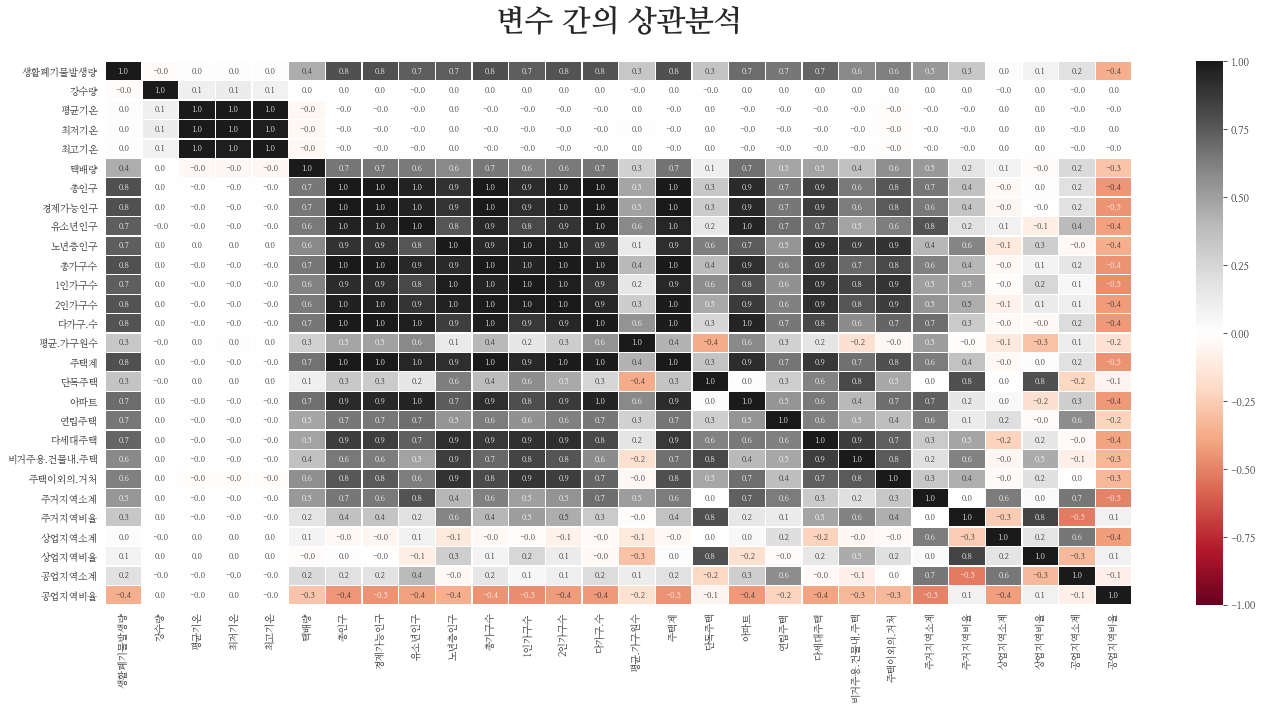

In [49]:
plt.figure(figsize = (23,10))
sns.heatmap(data.corr(), cmap='RdGy', linewidth = 0.3, annot= True, fmt = '.1f', annot_kws={'size':8},
           vmin = -1, vmax =1)
#plt.xticks(rotation = 70)
plt.title('변수 간의 상관분석', size = 30, fontweight = 'bold', pad = 30)
#plt.savefig('./image/전체변수간의상관분석.png',bbox_inches='tight')

### 관련 변수 간 상세 비교 

In [50]:
tmp1 = data[['생활폐기물발생량','강수량','평균기온','최저기온','최고기온']]
tmp2 = data[['생활폐기물발생량','총인구','경제가능인구','유소년인구','노년층인구']]
tmp3 = data[['생활폐기물발생량','총인구','총가구수','1인가구수','2인가구수','다가구.수','평균.가구원수']]
tmp4 = data[['생활폐기물발생량','총인구','주택계','단독주택','아파트','연립주택','다세대주택','비거주용.건물내.주택','주택이외의.거처']]
tmp5 = data[['생활폐기물발생량','총인구','주거지역소계','주거지역비율','상업지역소계','상업지역비율','공업지역소계','공업지역비율']]

In [51]:
tmp = [tmp1, tmp2, tmp3, tmp4, tmp5]

In [52]:
tmp[2].head()

,생활폐기물발생량,총인구,총가구수,1인가구수,2인가구수,다가구.수,평균.가구원수
0,115160.952,339209,116403,24111,28291,64001,2.700
1,126700.952,339209,116403,24111,28291,64001,2.700
2,117700.952,339209,116403,24111,28291,64001,2.700
3,98380.952,339209,116403,24111,28291,64001,2.700
4,115200.952,339209,116403,24111,28291,64001,2.700


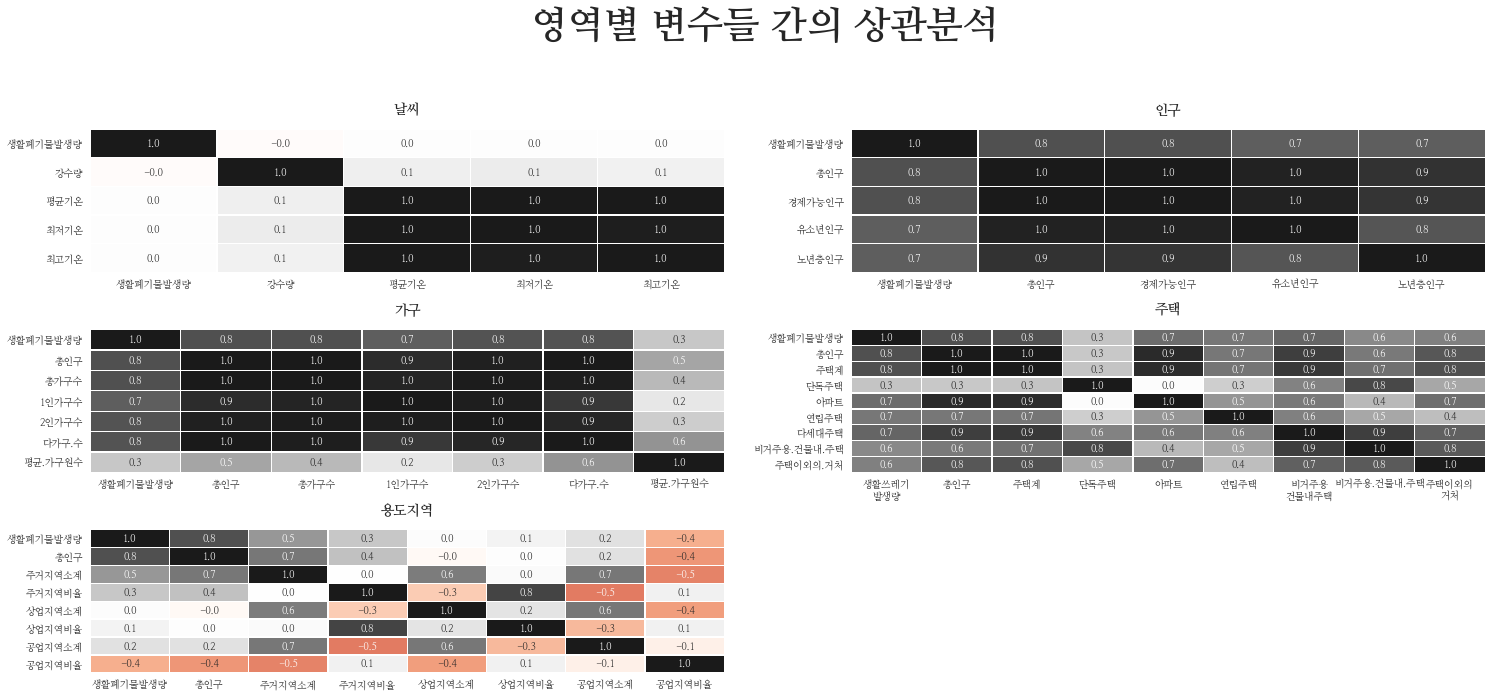

In [53]:
fig, ax = plt.subplots(3,2, figsize = (25,10))
plt.subplots_adjust(hspace = 0.4)

ax[-1,-1].axis('off')

for i in range(5):
    im = sns.heatmap(tmp[i].corr(), ax = ax.flat[i], cmap = 'RdGy',cbar= False, 
                vmin = -1, vmax = 1,linewidth = 0.3, annot = True, fmt = '.1f', annot_kws = {'size' : 10})

ax.flat[0].set_title('날씨', fontsize = 14, fontweight ='bold', pad = 15)
ax.flat[1].set_title('인구',fontsize = 14, fontweight ='bold', pad = 15)
ax.flat[2].set_title('가구',fontsize = 14, fontweight ='bold', pad = 15)
ax.flat[3].set_title('주택',fontsize = 14, fontweight ='bold', pad = 15)
주택_label = [item.get_text() for item in ax.flat[3].get_xticklabels()]
주택_label[0] = '생활쓰레기\n발생량'
주택_label[6] = '비거주용\n건물내주택'
주택_label[-1] = '주택이외의\n거처'
ax.flat[3].set_xticklabels(주택_label, rotation ='horizontal')
ax.flat[4].set_title('용도지역',fontsize = 14, fontweight ='bold', pad = 15)

fig.suptitle('영역별 변수들 간의 상관분석', size = 38, fontweight = 'bold', y = 1.05)
plt.savefig('./image/영역별변수간의상관분석.png', bbox_inches ='tight')

#### 다중공선성
이후 회귀 모델에 적합하기 위해선 독립변수들이 서로 독립성을 가지고 있어야 하기 때문에 서로 상관성인 너무 높은 변수들을 처리해주어야 한다.  
서로 상관성이 높은 변수들 중 모델에 더 유용한 의미가 있을거라고 판단되는 것을 제외하고 변수를 제거한다. 


### 사용 독립 변수 
앞선 EDA 결과와 상관분석 결과를 토대로 예측 모델링에 사용할 변수 선택 

    * 가구 : 평균 가구원수 
    * 주택 : 아파트, 단독주택, 연립주택, 다세대주택
    * 택배량
    
### 종속 변수 : 생활폐기물발생량

In [54]:
temp = data[['평균.가구원수','아파트','단독주택','연립주택', '다세대주택','택배량']]

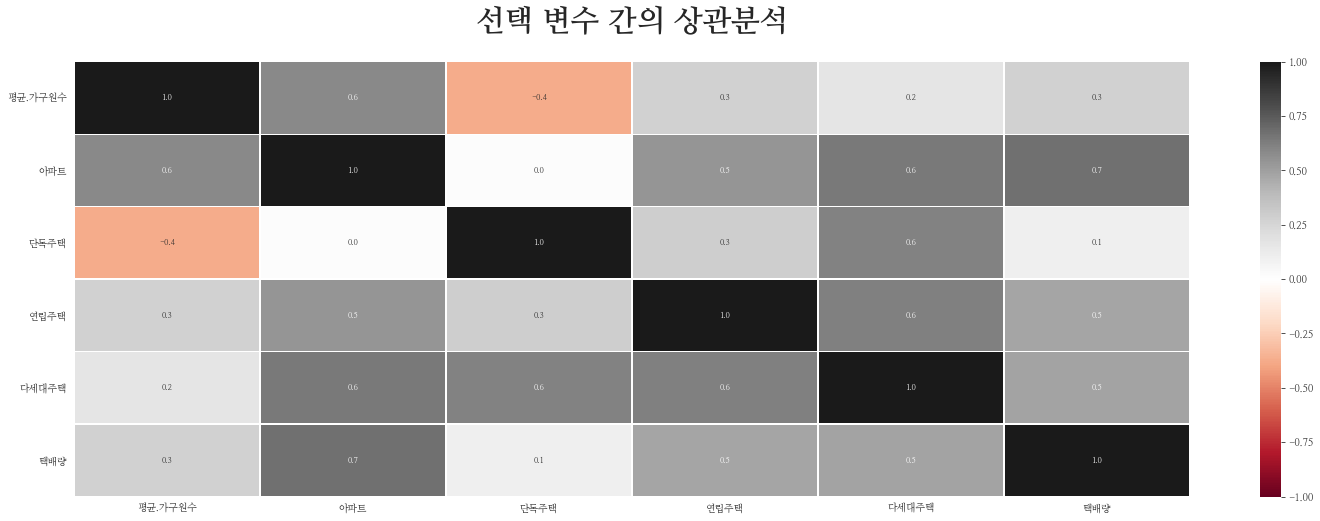

In [55]:
plt.figure(figsize = (25,8))
sns.heatmap(temp.corr(),  cmap='RdGy', linewidth = 0.3, annot= True, fmt = '.1f', annot_kws={'size':8}, vmin = -1, vmax =1)
plt.yticks(rotation ='horizontal')
plt.title('선택 변수 간의 상관분석', size = 30, fontweight = 'bold', pad = 30)
plt.savefig('./image/선택 변수 간의 상관분석.png', bbox_inches = 'tight')

택배량은 인구와 연관이 높은 변수 임으로 아파트와 상관성이 0.7로 높은 편이나 택배량에 대한 생활폐기물발생량에 대한 연관성을 파악하기 위해 필요. 

In [56]:
c_data = data[['날짜','구별','생활폐기물발생량','평균.가구원수','아파트','단독주택','연립주택','택배량']]

In [57]:
c_data.head()

,날짜,구별,생활폐기물발생량,평균.가구원수,아파트,단독주택,연립주택,택배량
0,2015-01-02,계양구,115160.952,2.700,68277,4079,2108,2814.000
1,2015-01-05,계양구,126700.952,2.700,68277,4079,2108,3345.000
2,2015-01-06,계양구,117700.952,2.700,68277,4079,2108,5728.000
3,2015-01-07,계양구,98380.952,2.700,68277,4079,2108,3764.000
4,2015-01-08,계양구,115200.952,2.700,68277,4079,2108,3646.000


### Index 제외

(`날짜`, `구별`) 변수는 데이터에 대한 index 값으로 모델링 작업 전 제거해야한다.   
생활폐기물발생량에 영향을 주는 지역변수를 찾아내는 것이 목표.  

In [58]:
withoutIndex = c_data.iloc[:,2:]

In [59]:
withoutIndex.head()

,생활폐기물발생량,평균.가구원수,아파트,단독주택,연립주택,택배량
0,115160.952,2.700,68277,4079,2108,2814.000
1,126700.952,2.700,68277,4079,2108,3345.000
2,117700.952,2.700,68277,4079,2108,5728.000
3,98380.952,2.700,68277,4079,2108,3764.000
4,115200.952,2.700,68277,4079,2108,3646.000


## Modeling

일일 생활폐기물발생량을 예측하고자 한다.  
종속변수 y = '생활폐기물발생량' 으로 두어 예측 모델링 실시

In [60]:
withoutIndex.rename(columns = {'평균.가구원수' :'평균_가구원수'}, inplace = True)

### 최소자승법 OLS를 활용한 회귀분석

In [61]:
fit = ols('생활폐기물발생량 ~ 평균_가구원수 + 아파트 + 단독주택 + 연립주택 + 택배량', 
         data = withoutIndex).fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               생활폐기물발생량   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     3616.
Date:                Tue, 22 Dec 2020   Prob (F-statistic):               0.00
Time:                        16:16:38   Log-Likelihood:            -1.1487e+05
No. Observations:                9427   AIC:                         2.298e+05
Df Residuals:                    9421   BIC:                         2.298e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -5.411e+04   1.18e+04     -4.581      0.000   -7.73e+04    -3.1e+04
평균_가구원수      1.86e+04   4717.548      3.943      0.000    9354.873    2.78e+04
아파트            1.3080      0.023     57.888      0.000       1.264       1.352
단독주택           3.9487      0.106     37.118      0.000       3.740       4.157
연립주택          10.4142      0.262     39.702      0.000       9.900      10.928
택배량           -3.2292      0.180    -17.989      0.000      -3.581      -2.877
==============================================================================
Omnibus:                      808.245   Durbin-Watson:                   1.147
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1895.563
Skew:                           0.527   Prob(JB):                         0.00
Kurtosis:                       4.927   Cond. No.                     2.20e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
y = withoutIndex.iloc[:,0]
X = withoutIndex.iloc[:,1:]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

### 1. 일반 다중 회귀 분석 

시간적 요소를 고려하지 않은 일반 다중회귀 분석 모델링

In [64]:
lr = LinearRegression()

In [65]:
lr.fit(X_train, y_train)

LinearRegression()

In [66]:
pred = lr.predict(X_test)

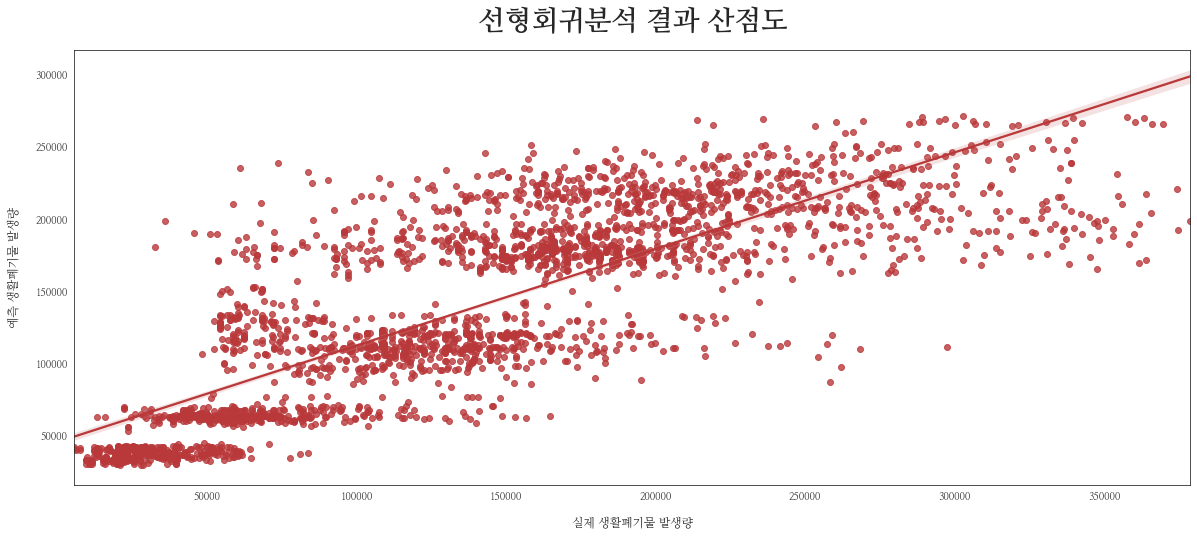

In [67]:
plt.figure(figsize = (20,8))
sns.regplot(y_test, pred, color = '#B9383A',
           fit_reg=True) # default

plt.title('선형회귀분석 결과 산점도', size = 28, fontweight='bold', pad= 20 )
plt.xlabel('실제 생활폐기물 발생량', labelpad = 15, fontsize = 12)
plt.ylabel('예측 생활폐기물 발생량', labelpad = 15, fontsize = 12)
plt.savefig('./image/선형회귀분석 결과산점도.png', bbox_inches = 'tight')

### 모델 평가 지표

    * MSE 
    * R2 

In [68]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

In [69]:
mse = mean_squared_error(y_test, pred)
mse

2186102060.5774164

In [70]:
rmse = np.sqrt(mse)
rmse

46755.77034524633

#### R2 결정계수 

In [71]:
r2 = r2_score(y_test, pred)
r2

0.6672174479810644

In [72]:
df = pd.DataFrame({'actual' : y_test, 'predicted': pred})

In [73]:
df.head()

,actual,predicted
2871,48050.000,63376.019
4826,160761.905,211322.867
1717,28730.000,41035.938
804,112751.111,103885.549
3257,61989.412,61280.266


In [74]:
coeff_df = pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
평균_가구원수,20632.677
아파트,1.312
단독주택,3.995
연립주택,10.270
택배량,-3.245


In [75]:
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import make_pipeline

In [76]:
lr_2 = make_pipeline(StandardScaler(), LinearRegression())
lr_2.fit(X_train, y_train)
pred = lr_2.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

46755.77034524633

In [77]:
r2 = r2_score(y_test, pred)
r2

0.6672174479810644

### SGDRegressor 

In [78]:
from sklearn.linear_model import SGDRegressor

In [79]:
reg = make_pipeline(StandardScaler(), SGDRegressor())
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

46764.18570652824

In [80]:
r2 = r2_score(y_test, pred)
r2

0.6670976451243785

### RandomForest Regressor

In [81]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
rf_p = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators = 1000, random_state = 0))

In [83]:
rf_p.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=1000, random_state=0))])

In [84]:
pred = rf_p.predict(X_test)
r2 = r2_score(y_test, pred)
r2

0.6276259544467933

### 범주화 : 생활폐기물 발생량 

In [85]:
from sklearn.cluster import KMeans

In [86]:
km = KMeans(5)

withoutIndex['label'] = km.fit_predict(withoutIndex[['생활폐기물발생량']])

In [87]:
withoutIndex.head()

,생활폐기물발생량,평균_가구원수,아파트,단독주택,연립주택,택배량,label
0,115160.952,2.700,68277,4079,2108,2814.000,2
1,126700.952,2.700,68277,4079,2108,3345.000,2
2,117700.952,2.700,68277,4079,2108,5728.000,2
3,98380.952,2.700,68277,4079,2108,3764.000,2
4,115200.952,2.700,68277,4079,2108,3646.000,2


In [88]:
withoutIndex.groupby('label').label.count()

label
0    2695
1    1382
2    2152
3     661
4    2537
Name: label, dtype: int64

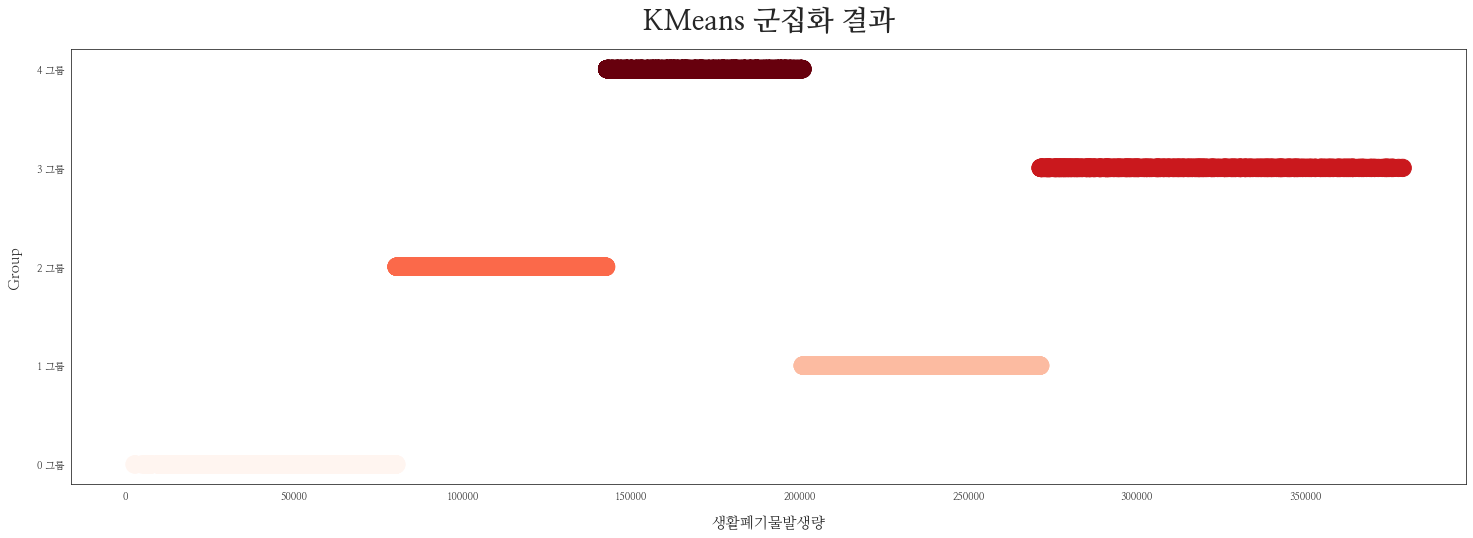

In [89]:
plt.figure(figsize = (25, 8))

plt.scatter(withoutIndex['생활폐기물발생량'], withoutIndex['label'], c=withoutIndex['label'], s=300, cmap ='Reds')

plt.xlabel('생활폐기물발생량', size = 15, labelpad = 15)
plt.ylabel('Group', size = 15, labelpad = 15)
plt.yticks([0, 1, 2, 3, 4], ['{} 그룹'.format(x) for x in range(5)])

plt.title('KMeans 군집화 결과', size = 28, fontweight='bold', pad= 20 )

plt.savefig('./image/Kmeans군집화.png', bbox_inches = 'tight')

In [106]:
withoutIndex['label2'] = np.where(withoutIndex['label']  != 3, 0, 1)

In [107]:
withoutIndex.groupby('label2').label2.count()

label2
0    8766
1     661
Name: label2, dtype: int64

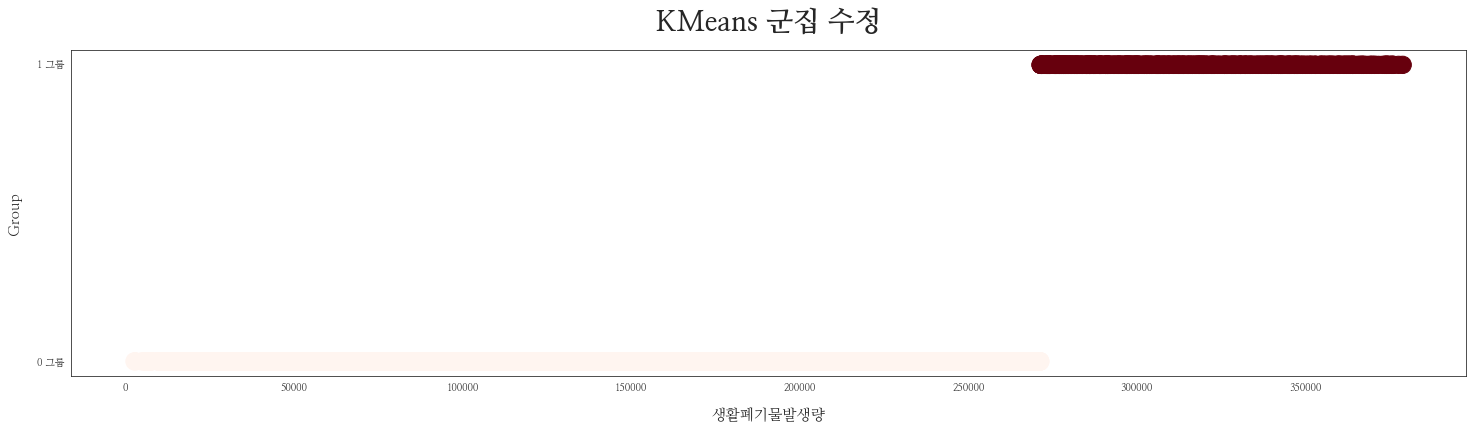

In [108]:
plt.figure(figsize = (25, 6))

plt.scatter(withoutIndex['생활폐기물발생량'], withoutIndex['label2'], c=withoutIndex['label2'], s=300, cmap ='Reds')

plt.xlabel('생활폐기물발생량', size = 15, labelpad = 15)
plt.ylabel('Group', size = 15, labelpad = 15)
plt.yticks([0, 1], ['{} 그룹'.format(x) for x in range(5)])

plt.title('KMeans 군집 수정', size = 28, fontweight='bold', pad= 20 )

plt.savefig('./image/Kmeans군집화_수정.png', bbox_inches = 'tight')

In [109]:
from sklearn.linear_model import LogisticRegression

In [110]:
model = make_pipeline(StandardScaler(), LogisticRegression())

In [111]:
y = withoutIndex['label2']
x = withoutIndex[['평균_가구원수', '아파트','단독주택','연립주택','택배량' ]]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [113]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [114]:
from sklearn.metrics import accuracy_score

In [115]:
pred = model.predict(X_test)

accuracy_score(y_test, pred)

0.9369034994697774

In [116]:
model.score(X_train, y_train)

0.9340936215356054

In [117]:
pd.DataFrame(model['logisticregression'].coef_.transpose(), x.columns, columns = ['Coeff'])

,Coeff
평균_가구원수,-0.728
아파트,1.830
단독주택,0.618
연립주택,1.108
택배량,-0.511


In [118]:
model['logisticregression'].intercept_

array([-4.15207272])

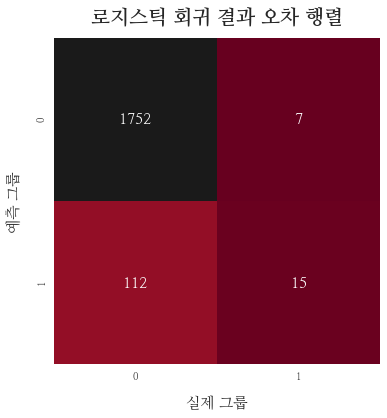

In [119]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (6,6))
mat = confusion_matrix(pred, y_test)
sns.heatmap(mat.T, square = True, annot = True, fmt ='d', cbar = False, cmap = 'RdGy',
           annot_kws ={'size' : 15})

plt.xlabel('실제 그룹', size = 15, labelpad = 15 )
plt.ylabel('예측 그룹', size = 15, labelpad = 15 )

plt.title('로지스틱 회귀 결과 오차 행렬', size =20, pad = 15, weight = 'bold')
plt.savefig('로지스틱 회귀 결과 오차행렬.png',bbox_inches = 'tight')

In [120]:
from sklearn.metrics import classification_report

In [121]:
print(classification_report(y_test, pred)) 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1759
           1       0.68      0.12      0.20       127

    accuracy                           0.94      1886
   macro avg       0.81      0.56      0.58      1886
weighted avg       0.92      0.94      0.92      1886

